 user_id  similarity
     773    0.204792
     868    0.202321
     592    0.196592
     880    0.195801
     429    0.190661
     276    0.187476
     916    0.186358
     222    0.182415
     457    0.182253
       8    0.180891


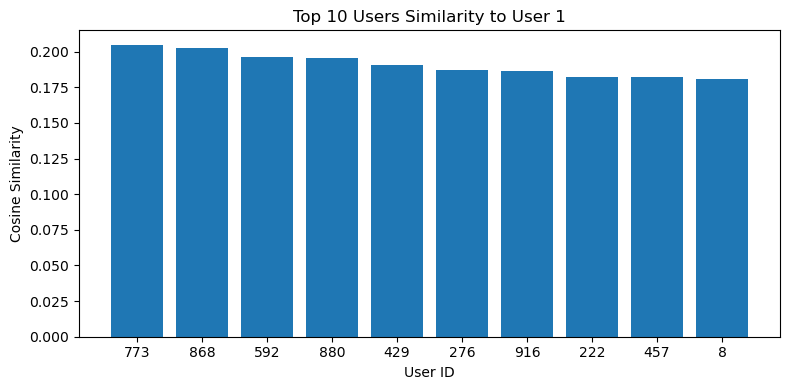


Predicted rating for user 1 on item 508: 4.200


In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(url, sep='\t', names=col_names)

utility = ratings.pivot(index='user_id', columns='item_id', values='rating')
user_means = utility.mean(axis=1)
utility_centered = utility.sub(user_means, axis=0)

matrix_filled = utility_centered.fillna(0)
sim_matrix = pd.DataFrame(
    cosine_similarity(matrix_filled),
    index=matrix_filled.index,
    columns=matrix_filled.index
)

sim_to_1 = sim_matrix.loc[1].drop(labels=1)
top10 = sim_to_1.nlargest(10)

result = pd.DataFrame({
    'user_id': top10.index,
    'similarity': top10.values
})
print(result.to_string(index=False))

plt.figure(figsize=(8, 4))
plt.bar(result['user_id'].astype(str), result['similarity'])
plt.title('Top 10 Users Similarity to User 1')
plt.xlabel('User ID')
plt.ylabel('Cosine Similarity')
plt.tight_layout()
plt.show()

ratings_508 = utility.loc[top10.index, 508]
predicted_rating = ratings_508.mean()
print(f"\nPredicted rating for user 1 on item 508: {predicted_rating:.3f}")


User 200 vs Item 95 → Similarity: 0.1999, Distance: 0.8001
User 15  vs Item 95 → Similarity: -0.0206,  Distance: 1.0206


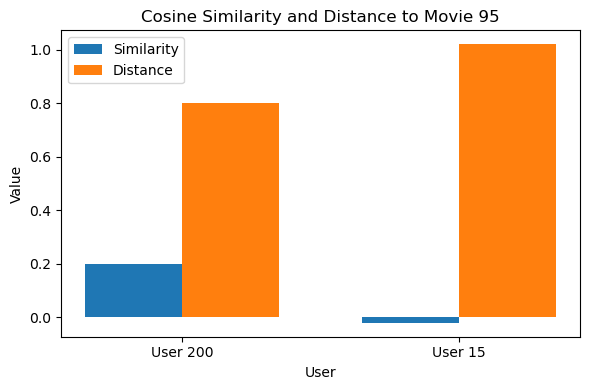

Recommend item 95 to User 200.


In [6]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1. Load ratings from URL
url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(url, sep='\t', names=cols)

# 2. Build utility matrix and center by subtracting each user’s mean
utility = ratings.pivot(index='user_id', columns='item_id', values='rating')
user_means = utility.mean(axis=1)
centered = utility.sub(user_means, axis=0).fillna(0)

# 3. Decompose into 20 latent factors
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(centered)   # shape: (943 users, 20)
item_factors = svd.components_.T             # shape: (1682 items, 20)

# 4. Extract latent vectors for User 200, User 15, and Item 95
u200 = user_factors[199].reshape(1, -1)      # index 199 corresponds to user_id=200
u15  = user_factors[14].reshape(1, -1)       # index 14  corresponds to user_id=15
i95  = item_factors[94].reshape(1, -1)       # index 94  corresponds to item_id=95

# 5. Compute cosine similarity and distance
sim_200 = cosine_similarity(u200, i95)[0, 0]
sim_15  = cosine_similarity(u15,  i95)[0, 0]
dist_200 = 1 - sim_200
dist_15  = 1 - sim_15

print(f"User 200 vs Item 95 → Similarity: {sim_200:.4f}, Distance: {dist_200:.4f}")
print(f"User 15  vs Item 95 → Similarity: {sim_15:.4f},  Distance: {dist_15:.4f}")

# 6. Plot similarity and distance side by side
users = ['User 200', 'User 15']
similarities = [sim_200, sim_15]
distances    = [dist_200, dist_15]

x = range(len(users))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x, similarities, width, label='Similarity')
plt.bar([xi + width for xi in x], distances, width, label='Distance')
plt.xticks([xi + width/2 for xi in x], users)
plt.xlabel('User')
plt.ylabel('Value')
plt.title('Cosine Similarity and Distance to Movie 95')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Recommendation decision
if sim_200 > sim_15:
    print("Recommend item 95 to User 200.")
else:
    print("Recommend item 95 to User 15.")
